# WORKFLOW 
Implement OCR -> Receive Input(Image) -> OCR -> Entity Recognition -> Search, Process, Classify with Probability score, Report with stats and details
<hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Importing Libraries

In [2]:
!pip install flair --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.29.165 which is incompatible.


In [3]:
!pip install -U duckduckgo_search --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import plotly.express as px
import duckduckgo_search
import cv2
from flair.models import SequenceTagger
from flair.data import Sentence
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from duckduckgo_search import ddg_images
import re
import PIL
from fastdownload import download_url
from time import sleep

In [5]:
def ViewImage(image_path,figure_size=None): 
    """
    Display and return an image from the given file path.

    Parameters:
        image_path (str): The path to the image file.
        figure_size (tuple, optional): The size of the figure for displaying the image. Defaults to None.

    Returns:
        numpy.ndarray: The image as a NumPy array.

    Raises:
        FileNotFoundError: If the image file does not exist."""
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    plt.figure(figsize=figure_size)
    plt.imshow(image)
    return image
    

In [6]:
def perform_search(query):
    """Execute search for the inputted query"""
    search_results = []
    url = f"https://duckduckgo.com/html/?q={query}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    results = soup.select('.result__url')
    for result in results:
        search_results.append(result.text)
    return search_results

In [7]:
def select_search(Tag1,Tag2=None):
    """
    Select and combine terms based on the provided tags.

    Parameters:
        Tag1 (str): The first tag to filter the DataFrame.
        Tag2 (str, optional): The second tag to filter the DataFrame. Defaults to None.

    Returns:
        pandas.Series: The combined terms from the filtered DataFrame.

    Raises:
        KeyError: If the provided tags are not present in the DataFrame.
    """
    # TAG1
    tag1 = df[df['Tag'] == Tag1]
    tag1.reset_index(inplace=True)
    tag1 = tag1.drop(['index','Tag'],axis=1)
    # TAG2
    tag2 = df[df['Tag'] == Tag2]
    tag2 = tag2.reset_index()
    tag2 = tag2.drop(['index','Tag'],axis=1)
    
    if Tag2 is not None:
        TERMS = pd.Series([(i +' '+j) for i in tag1.values for j in tag2.values])
    else:
        TERMS = pd.Series([i for i in tag1.values])
    return TERMS

In [8]:
def filter_linkedin_urls(strings):
    """Filter string for linkedin urls"""
    pattern = r"(?:http[s]?://)?(?:www\.)?linkedin\.com/(?:in|company)/[\w-]+"
    filtered_urls = [string.strip() for string in strings if re.search(pattern, string)]
    return filtered_urls

In [9]:
def NameMatcher():
    """Return a list consisting of results which match Entity - Person's name"""
    return [result for result in results for person in persons if person in result]

In [10]:
def search_images(term, max_images):
    """Search images """
    print(f'searching for {term}')
    return (ddg_images(keywords=term,max_results=max_images))

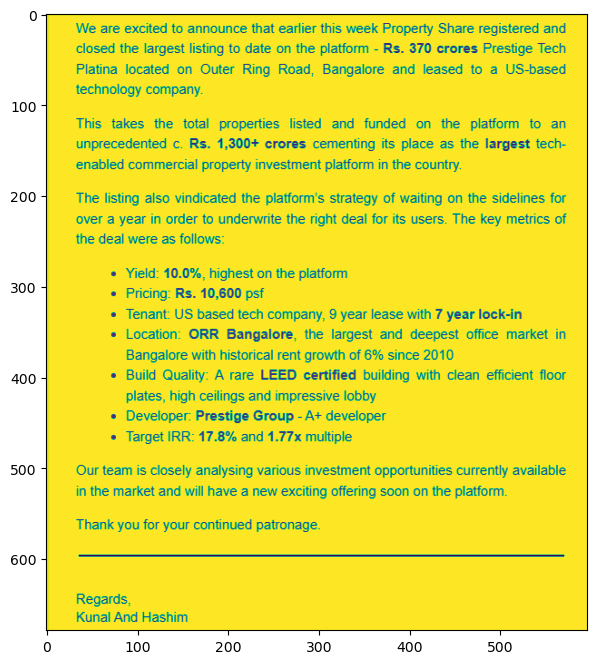

In [11]:
image = ViewImage('/kaggle/input/ocr-gen-2/OCR_genuineity/property share.png',(10,8))

In [12]:
data = pytesseract.image_to_string(image)
print(f'Extracted Raw data: \n\n{data}\n')

Extracted Raw data: 

We are excited to announce that earlier this week Property Share registered and
closed the largest listing to date on the platform - Rs. 370 crores Prestige Tech
Platina located on Outer Ring Road, Bangalore and leased to a US-based
technology company.

This takes the total properties listed and funded on the platform to an
unprecedented c. Rs. 1,300+ crores cementing its place as the largest tech-
enabled commercial property investment platform in the country,

The listing also vindicated the platform's strategy of waiting on the sidelines for
over a year in order to underwrite the right deal for its users. The key metrics of
the deal were as follows

* Yield: 10.0%, highest on the platform

* Pricing: Rs. 10,600 psf

+ Tenant: US based tech company, 9 year lease with 7 year lock-in

* Location: ORR Bangalore, the largest and deepest office market in
Bangalore with historical rent growth of 6% since 2010

* Build Quality: A rare LEED certified building with clean

In [13]:
ENTITY = []
TAG = []

# Load the pre-trained NER model
tagger = SequenceTagger.load('ner')
text = data
# Create a Sentence object
sentence = Sentence(text)

# Run NER on the sentence
tagger.predict(sentence)


for entity in sentence.get_spans('ner'):
    ENTITY.append(entity.text)
    TAG.append(entity.tag)
    
df = pd.DataFrame({'Entity':ENTITY,'Tag':TAG})
df

2023-07-16 09:38:36,010 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


,Entity,Tag
0,Property Share,ORG
1,Prestige Tech Platina,ORG
2,Outer Ring Road,LOC
3,Bangalore,LOC
4,US-based,MISC
5,US,LOC
6,ORR Bangalore,ORG
7,Bangalore,LOC
8,Kunal,PER
9,Hashim,PER


In [14]:
PERSONs = df[df['Tag'] == 'PER']['Entity'].str.lower()

In [15]:
persons = PERSONs.to_list()

### Searching for Key members in organization

In [16]:
search_tags = select_search('ORG','PER')
search_tags

0            [Property Share Kunal]
1           [Property Share Hashim]
2     [Prestige Tech Platina Kunal]
3    [Prestige Tech Platina Hashim]
4             [ORR Bangalore Kunal]
5            [ORR Bangalore Hashim]
dtype: object

In [17]:
SEARCH_TAG = search_tags[0]

In [18]:
search_query = SEARCH_TAG

results = perform_search(search_query)
print(f'\n\nSearching for {search_query}')
for result in results:
    print(result)



Searching for ['Property Share Kunal']

                  www.propertyshare.in/about-us
                  

                  theorg.com/org/property-share/org-chart/kunal-moktan
                  

                  www.linkedin.com/company/propertyshare
                  

                  yourstory.com/companies/property-share
                  

                  yourstory.com/companies/property-share?origin=awards
                  

                  www.propsharecapital.com/about-us
                  

                  yourstory.com/2015/07/property-ownership-sharing
                  

                  economictimes.indiatimes.com/magazines/panache/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course/articleshow/51221042.cms
                  

                  yourstory.com/2019/03/funding-alert-property-share-lightspeed-ventures-pdrkp8pgsd
                  

                  www.facebook.com/propertyshare.in/posts/773276299539330
                  

In [19]:
processed_results = str(results).replace("'",'').replace('\\n','').replace('[','').replace(']','').lower().split(',')

In [20]:
[link for link in processed_results for person in persons if person in link]

['                   theorg.com/org/property-share/org-chart/kunal-moktan                  ',
 '                   economictimes.indiatimes.com/magazines/panache/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course/articleshow/51221042.cms                  ',
 '                   www.zaubacorp.com/company/kunal-holdings-and-properties-pvt-ltd/u65993up1982ptc005845                  ',
 '                   www.zoominfo.com/p/kunal-moktan/1605033398                  ']

In [21]:
for person in persons:
   # print(person)
    for link in processed_results:
    #    print(link)
        if person in link:
            print(link)

                   theorg.com/org/property-share/org-chart/kunal-moktan                  
                   economictimes.indiatimes.com/magazines/panache/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course/articleshow/51221042.cms                  
                   www.zaubacorp.com/company/kunal-holdings-and-properties-pvt-ltd/u65993up1982ptc005845                  
                   www.zoominfo.com/p/kunal-moktan/1605033398                  


In [22]:
persons[0] in processed_results[2]

False

In [23]:
persons

['kunal', 'hashim']

## CATEGORIZING RESULTS

#### LinkedIn urls

In [24]:
linkedin_urls = filter_linkedin_urls(results)
linkedin_urls

['www.linkedin.com/company/propertyshare']

#### Results matching person names

In [25]:
Person_names = NameMatcher()
Person_names

['\n                  theorg.com/org/property-share/org-chart/kunal-moktan\n                  ',
 '\n                  economictimes.indiatimes.com/magazines/panache/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course/articleshow/51221042.cms\n                  ']

In [26]:
result_images = search_images(SEARCH_TAG,10)
images = [image['image'] for image in result_images]
images

searching for ['Property Share Kunal']


['https://img.etimg.com/thumb/msid-51221235,width-643,imgsize-210435,resizemode-4/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course.jpg',
 'https://i.ytimg.com/vi/_5yCbKa_Ul0/maxresdefault.jpg?sqp=-oaymwEmCIAKENAF8quKqQMa8AEB-AH-CYAC0AWKAgwIABABGBMgJih_MA8=&rs=AOn4CLA7JA7QdwgMtKaNHPlQA9DuBH3gAQ',
 'https://images.yourstory.com/cs/2/6b393640-140e-11e9-87e2-f7248b252f46/property_share_founders1553572034099.png?fm=auto&ar=1:1&mode=crop&crop=faces&blur=50',
 'https://i.pinimg.com/236x/0e/ca/e9/0ecae9e4ca9b2cc0d88c14208c011dea--mumbai-flats.jpg',
 'https://superadmin.homes247.in/images/uploadPropertyImgs/1652510894-aspiree+(1).jpg',
 'https://www.propertydiscuss.com/photos/main/28ca5cc49d0bbd1032a33542293a16f7.jpg',
 'https://rachanaa.com/wp-content/uploads/2017/02/ele1.jpg',
 'https://superadmin.homes247.in/images/uploadPropertyImgs/1649222639-8-50.jpg',
 'https://www.propertycrow.com/photos/1798/photo-14883.jpeg',
 'https://i.pinimg.com/originals/c4/16/38/c41638ed18

In [27]:
downloaded_images = []
print('IMAGE LINKS:')
for i,img in enumerate(images):
    try:
        print(i,img)
    except:
        print(i+1)

IMAGE LINKS:
0 https://img.etimg.com/thumb/msid-51221235,width-643,imgsize-210435,resizemode-4/kunal-moktan-ceo-property-share-opens-up-on-why-he-loves-the-golf-course.jpg
1 https://i.ytimg.com/vi/_5yCbKa_Ul0/maxresdefault.jpg?sqp=-oaymwEmCIAKENAF8quKqQMa8AEB-AH-CYAC0AWKAgwIABABGBMgJih_MA8=&rs=AOn4CLA7JA7QdwgMtKaNHPlQA9DuBH3gAQ
2 https://images.yourstory.com/cs/2/6b393640-140e-11e9-87e2-f7248b252f46/property_share_founders1553572034099.png?fm=auto&ar=1:1&mode=crop&crop=faces&blur=50
3 https://i.pinimg.com/236x/0e/ca/e9/0ecae9e4ca9b2cc0d88c14208c011dea--mumbai-flats.jpg
4 https://superadmin.homes247.in/images/uploadPropertyImgs/1652510894-aspiree+(1).jpg
5 https://www.propertydiscuss.com/photos/main/28ca5cc49d0bbd1032a33542293a16f7.jpg
6 https://rachanaa.com/wp-content/uploads/2017/02/ele1.jpg
7 https://superadmin.homes247.in/images/uploadPropertyImgs/1649222639-8-50.jpg
8 https://www.propertycrow.com/photos/1798/photo-14883.jpeg
9 https://i.pinimg.com/originals/c4/16/38/c41638ed18c8811

In [28]:
for i,img in enumerate(images):
    try:
        downloaded_images.append(download_url(img,f'img{i}.jpg',show_progress=False))
    except:
        print(f'Failed img {img} at index {i}')
        continue

Failed img https://superadmin.homes247.in/images/uploadPropertyImgs/1652510894-aspiree+(1).jpg at index 4


#### Test if image is download is valid

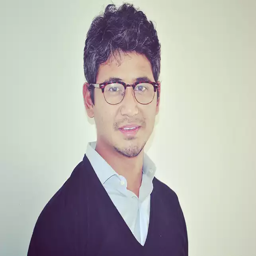

In [29]:
i = PIL.Image.open(downloaded_images[0])
i.resize((256,256))

### Plotting images

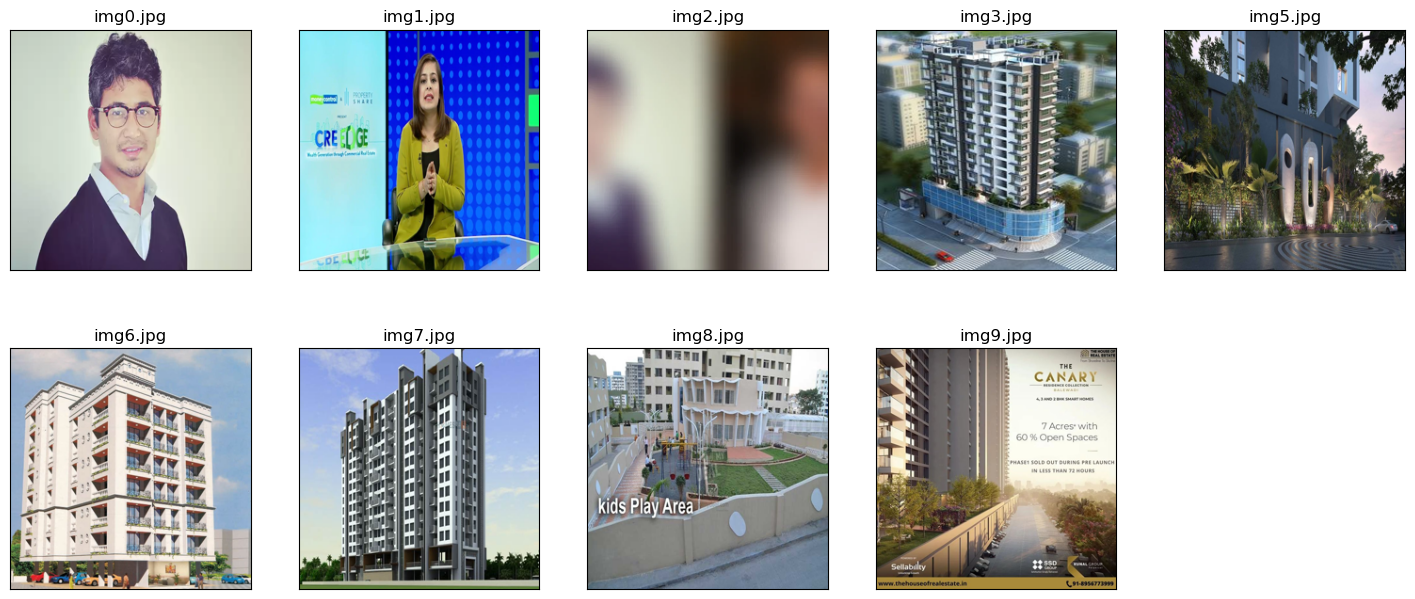

In [31]:
plt.figure(figsize=(18,20))
for i,image in enumerate(downloaded_images):
    plt.subplot(5,5,i+1)
    i = PIL.Image.open(image)
    i = i.resize((256,256))
    plt.title(f'{image}')
    plt.xticks(ticks=[])
    plt.yticks([])
    plt.imshow(i)

Note: The information or the images extracted are not used for any purpose,they are all extracted on publically available resources